In [2]:
#import packages
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import preprocessing
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt 
import operator
import collections
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, chi2, f_classif
#from imblearn.over_sampling import SMOTE
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.neural_network import MLPClassifier
#from keras.layers import Dense, Activation
#from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

# Deep Learning

In [12]:
path = "C:\\Users\\Joana\\Desktop\\Uminho\\2_1\\SIB\\trab\\dataset"
rna_seq_tmp = pd.read_csv("GSE157103_genes.tpm.tsv", sep='\t', index_col = 0)

import GEOparse

#download and load to the memory the experiment with specific GEO accession
gse157103 = GEOparse.get_GEO("GSE157103")

metadata = gse157103.phenotype_data
print(metadata.head(35))

26-Jan-2021 01:40:16 DEBUG utils - Directory ./ already exists. Skipping.
26-Jan-2021 01:40:16 INFO GEOparse - File already exist: using local version.
26-Jan-2021 01:40:16 INFO GEOparse - Parsing ./GSE157103_family.soft.gz: 
26-Jan-2021 01:40:16 DEBUG GEOparse - DATABASE: GeoMiame
26-Jan-2021 01:40:16 DEBUG GEOparse - SERIES: GSE157103
26-Jan-2021 01:40:16 DEBUG GEOparse - PLATFORM: GPL24676
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753021
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753022
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753023
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753024
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753025
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753026
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753027
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753028
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753029
26-Jan-2021 01:40:16 DEBUG GEOparse - SAMPLE: GSM4753030
26-Jan-2021 01:40:16 DEBUG GEOpars

                                 title geo_accession                 status  \
GSM4753021    COVID_01_39y_male_NonICU    GSM4753021  Public on Aug 29 2020   
GSM4753022    COVID_02_63y_male_NonICU    GSM4753022  Public on Aug 29 2020   
GSM4753023    COVID_03_33y_male_NonICU    GSM4753023  Public on Aug 29 2020   
GSM4753024    COVID_04_49y_male_NonICU    GSM4753024  Public on Aug 29 2020   
GSM4753025    COVID_05_49y_male_NonICU    GSM4753025  Public on Aug 29 2020   
GSM4753026     COVID_06_:y_male_NonICU    GSM4753026  Public on Aug 29 2020   
GSM4753027  COVID_07_38y_female_NonICU    GSM4753027  Public on Aug 29 2020   
GSM4753028       COVID_08_78y_male_ICU    GSM4753028  Public on Aug 29 2020   
GSM4753029     COVID_09_64y_female_ICU    GSM4753029  Public on Aug 29 2020   
GSM4753030       COVID_10_62y_male_ICU    GSM4753030  Public on Aug 29 2020   
GSM4753031  COVID_11_52y_female_NonICU    GSM4753031  Public on Aug 29 2020   
GSM4753032       COVID_12_50y_male_ICU    GSM4753032

## Disease State

In [13]:
data_scaled = preprocessing.scale(rna_seq_tmp)
data_scaled.shape

(19472, 126)

#### Train and Test Split

In [14]:
disease_state=[]
for j in metadata["characteristics_ch1.0.disease state"]:
    if j == 'COVID-19':
        disease_state.append(int(1))
    if j == 'non-COVID-19':
        disease_state.append(int(0))
   
metadata['disease_state'] = disease_state

disease_state = metadata['disease_state']

ind = list(range(126))
np.random.seed(0)
indices = np.random.permutation(126)
data_scaled = data_scaled.T
train = data_scaled[ind]
x_train = train[indices[:-25]]
y_train = disease_state.iloc[indices[:-25]].values
x_test = data_scaled[indices[-25:]]
y_test = disease_state.iloc[indices[-25:]].values

In [15]:
print(data_scaled.shape)
print(y_test.shape)

(126, 19472)
(25,)


Foram selecionados os dados de RNA-seq e do disease_state do doente (2 tipos de outputs: COVID-19, non-COVID-19).

#### Feature Selection

In [16]:
selector = SelectPercentile(f_classif, percentile = 30)
train_select = selector.fit_transform(x_train, y_train)
index_top_feat = selector.get_support(indices= True)
print('Number of features selected:', index_top_feat.shape)

testin = x_test[:,index_top_feat]
testin.shape

Number of features selected: (5842,)


(25, 5842)

### Multi-Layer Perceptron (MLP)

In [20]:
mlp = MLPClassifier(solver='lbfgs', random_state=1)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)

print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred)))
print('Precision Score : ' + str(precision_score(y_test, y_pred)))
print('Recall Score : ' + str(recall_score(y_test, y_pred)))
print('F1 Score : ' + str(f1_score(y_test, y_pred)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6
Precision Score : 0.6666666666666666
Recall Score : 0.8235294117647058
F1 Score : 0.7368421052631577
Confusion Matrix : 
[[ 1  7]
 [ 3 14]]


### Cross Validation MLP

In [199]:
accuracy = cross_val_score (estimator =  mlp, X = train_select, y = y_train , cv = 5, n_jobs = -1)
print(f"Accuracy Scores: {accuracy} \n")
print(f'Accuracy Scores mean: {accuracy.mean()}')
print(f'Accuracy Scores sd: {accuracy.std()}')

Accuracy Scores: [0.61904762 0.7        0.6        0.5        0.65      ] 

Accuracy Scores mean: 0.6138095238095238
Accuracy Scores sd: 0.06619561473716246


#### Preprocessing for DNN

In [146]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

### Deep Neural Network (DNN)

In [165]:
model = Sequential()
model.add(Dense(16, activation = tf.nn.relu, input_shape=(19472,)))
model.add(Dense(16, activation = tf.nn.relu))
model.add(Dense(1, activation = tf.nn.sigmoid))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'], experimental_run_tf_function = False)

#### Validation Set

In [166]:
x_val = x_train[:85]
print(x_val)
partial_x_train = x_train[85:]
print(partial_x_train)
y_val = y_train[:85]
print(y_val)
partial_y_train = y_train[85:]
print(partial_y_train)

[[-0.06180409 -0.06241185 -0.06135435 ...  0.38333148 -0.04459232
  -0.05799951]
 [-0.0726122  -0.07291034 -0.07272577 ...  0.53202784 -0.05162889
  -0.06784198]
 [-0.05591123 -0.05615177 -0.0559987  ...  0.20924608 -0.04287805
  -0.05101286]
 ...
 [-0.03697962 -0.03763178 -0.0375292  ...  0.17699526 -0.03388735
  -0.03611496]
 [-0.04437932 -0.04474526 -0.04468426 ...  0.20966838 -0.02937588
  -0.04271517]
 [-0.02147003 -0.02155397 -0.0215246  ...  0.0969228  -0.01582089
  -0.02055089]]
[[-0.0598201  -0.06019518 -0.06011313 ...  0.41903841 -0.04232033
  -0.05732348]
 [-0.02937141 -0.02950354 -0.02944035 ...  0.06091594 -0.02475823
  -0.02749856]
 [-0.0203417  -0.02037344 -0.02036947 ...  0.02723196 -0.02007988
  -0.02021872]
 ...
 [-0.05302346 -0.05309584 -0.05307516 ...  0.27601182 -0.04253785
  -0.04830803]
 [-0.0675092  -0.06806586 -0.06782729 ...  0.38164827 -0.05065039
  -0.06302942]
 [-0.05193495 -0.05222989 -0.05212818 ...  0.399439   -0.04459206
  -0.05025687]]
[1. 1. 1. 1. 1. 

In [167]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
print('\nhistory dict_: \n', history.history)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6696 - accuracy: 0.5000 - val_loss: 1.5747 - val_accuracy: 0.1647
Epoch 2/20
1/1 [==============================] - 0s 80ms/step - loss: 1.0729 - accuracy: 0.2500 - val_loss: 0.4324 - val_accuracy: 0.8353
Epoch 3/20
1/1 [==============================] - 0s 88ms/step - loss: 0.5392 - accuracy: 0.7500 - val_loss: 0.4389 - val_accuracy: 0.8353
Epoch 4/20
1/1 [==============================] - 0s 80ms/step - loss: 0.4900 - accuracy: 0.7500 - val_loss: 0.4168 - val_accuracy: 0.8353
Epoch 5/20
1/1 [==============================] - 0s 89ms/step - loss: 0.4655 - accuracy: 0.7500 - val_loss: 0.4417 - val_accuracy: 0.8118
Epoch 6/20
1/1 [==============================] - 0s 100ms/step - loss: 0.4519 - accuracy: 0.8125 - val_loss: 0.4030 - val_accuracy: 0.8118
Epoch 7/20
1/1 [==============================] - 0s 195ms/step - loss: 0.3820 - accuracy: 0.8125 - val_loss: 0.4381 - val_accuracy: 0.8235
Epoch 8/20
1/1 [===========

In [168]:
res = model.evaluate(x_test, y_test, verbose = 0)
print('test loss, test acc:', res)

test loss, test acc: [0.7248357534408569, 0.7200000286102295]


Este modelo apresenta uma accuracy de 72% para uma classificação categórica entre 2 possíveis disease_status.

In [169]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

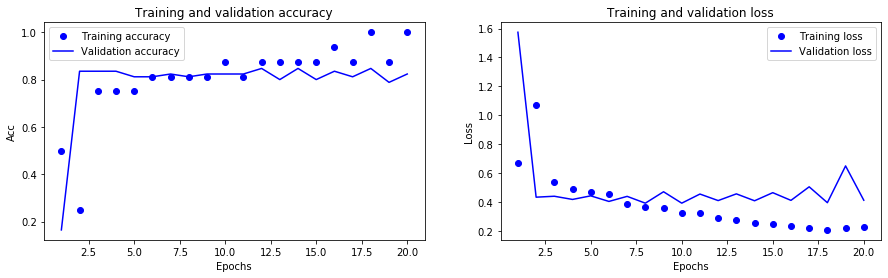

In [170]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.plot(epochs, acc_values, 'bo', label='Training accuracy')
ax1.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Acc')
ax1.legend()

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
ax2.plot(epochs, loss_values, 'bo', label='Training loss')
ax2.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

Verifica-se uma tendência de overfitting: a partir de ephoc 2 os valores de validation loss tendem a oscilar, enquanto que os do treino tendem a descer.

### DNN tuning

In [189]:
model = Sequential()
model.add(Dense(16, activation = tf.nn.relu, input_shape=(19472,)))
model.add(Dense(16, activation = tf.nn.relu))
model.add(Dense(1, activation = tf.nn.sigmoid))

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'], experimental_run_tf_function = False)

model.fit(x_train, y_train, epochs=3, batch_size=512)
res = model.evaluate(x_test, y_test)

Epoch 1/3
1/1 [==============================] - 1s 640ms/step - loss: 1.6915 - accuracy: 0.1782
Epoch 2/3
1/1 [==============================] - 0s 20ms/step - loss: 0.5961 - accuracy: 0.7723
Epoch 3/3
1/1 [==============================] - 0s 120ms/step - loss: 0.6621 - accuracy: 0.6800


In [190]:
print('test loss, test acc:', res)

test loss, test acc: [0.6621199250221252, 0.6800000071525574]


Verificou-se uma redução ligeira com a otimização do modelo para 68%.

## APACHE II - Numeric

#### Train and Test Split

In [1]:
metadata = metadata.reset_index()
metadata.head()

NameError: name 'metadata' is not defined

In [203]:
metadata['characteristics_ch1.4.apacheii'] = pd.to_numeric(metadata['characteristics_ch1.4.apacheii'],errors='coerce')
np.random.seed(0)
apac = metadata['characteristics_ch1.4.apacheii'].dropna()

indices = np.random.permutation(len(data_scaled[apac.index]))
train = data_scaled[apac.index]

x_train = train[indices[:-25]]
y_train = apac.iloc[indices[:-25]]

x_test = data_scaled[indices[-25:]]
y_test = apac.iloc[indices[-25:]]

In [204]:
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu',input_shape=(x_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

##### Cross Validation

In [206]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i + 1)
    val_data = x_train[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
    partial_train_data = np.concatenate( [x_train[:i*num_val_samples],x_train[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [y_train[:i*num_val_samples],y_train[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
print(all_scores)
print(np.mean(all_scores))

processing fold # 1
processing fold # 2
[6.008582592010498, 9.164878845214844]
7.586730718612671


In [208]:
num_epochs = 300 
all_mae_histories = []
for i in range(k):
    print('processing fold #', i) 
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [x_train[:i * num_val_samples], x_train[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate( [y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)
    model = build_model() 
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history['mae'] 
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1


In [209]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

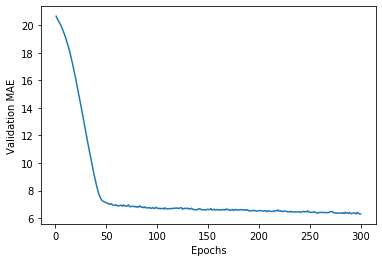

In [210]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

In [211]:
model = build_model()
model.fit(x_train, y_train, epochs=300, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
test_mae_score

1/1 [==============================] - 0s 208ms/step - loss: 60.6926 - mae: 6.3536


6.35359001159668

Foi construído um modelo de Deep Learning para o endpoit Severity Score APACHE II.
Este modelo produziu um MAE de 6 ao prever o y_test, o que significa que o modelo, em média, falha a previsão do score APACHE II em 6 pontos.
A magnitude elevada deste erro, para este endpoit, faz com que as previsões feitas pelo modelo não sejam relevantes o suficiente para a sua utilização.


## Ferritina

#### Train and Test Split

In [213]:
metadata['characteristics_ch1.10.ferritin (ng/ml)'] = pd.to_numeric(metadata['characteristics_ch1.10.ferritin (ng/ml)'],errors='coerce')
np.random.seed(0)
ferritin = metadata['characteristics_ch1.10.ferritin (ng/ml)'].dropna()

indices = np.random.permutation(len(data_scaled[ferritin.index]))
train = data_scaled[ferritin.index]

x_train = train[indices[:-25]]
y_train = ferritin.iloc[indices[:-25]]

x_test = data_scaled[indices[-25:]]
y_test = ferritin.iloc[indices[-25:]]

In [214]:
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu',input_shape=(x_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

##### Cross Validation

In [215]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i + 1)
    val_data = x_train[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
    partial_train_data = np.concatenate( [x_train[:i*num_val_samples],x_train[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [y_train[:i*num_val_samples],y_train[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
print(all_scores)
print(np.mean(all_scores))

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
[498.30584716796875, 638.90380859375, 577.3801879882812, 620.6045532226562]
583.7985992431641


In [216]:
num_epochs = 300 
all_mae_histories = []
for i in range(k):
    print('processing fold #', i) 
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [x_train[:i * num_val_samples], x_train[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate( [y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)
    model = build_model() 
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history['mae'] 
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [217]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

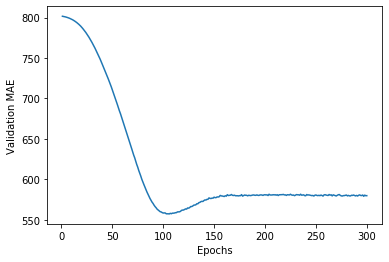

In [218]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

In [219]:
model = build_model()
model.fit(x_train, y_train, epochs=300, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
test_mae_score

1/1 [==============================] - 0s 150ms/step - loss: 1597684.7500 - mae: 799.0048


799.0048217773438

Foi construído um modelo de Deep Learning para o endpoit Ferritina(ng/ml).
Este modelo produziu um MAE de 799 ao prever o y_test, o que significa que o modelo, em média, falha a previsão do valor deste biomarcador em 799 ng/ml.
A magnitude elevada deste erro, para este endpoit, faz com que as previsões feitas pelo modelo não sejam relevantes o suficiente para a sua utilização.


In [220]:
metadata['characteristics_ch1.10.ferritin (ng/ml)']

0       946.0
1      1060.0
2      1335.0
3       583.0
4       800.0
        ...  
121       NaN
122      85.0
123       NaN
124       NaN
125       NaN
Name: characteristics_ch1.10.ferritin (ng/ml), Length: 126, dtype: float64